In [1]:
import numpy as np
import tensorflow as tf
import os
import pickle
import numpy.random as rnd
from sklearn.utils import shuffle

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load in data

In [2]:
import pickle
import boto3
from io import BytesIO

In [3]:
s3 = boto3.resource('s3')
data_subsets = ['train', 'val', 'test']
data = {}

for name in data_subsets:
    with BytesIO() as files:
        path = "omniglot_images/" +name+ ".pickle"
        s3.Bucket("research-paper-omniglot-data").download_fileobj(path, files)
        files.seek(0)    # move back to the beginning after writing
        (X,c) = pickle.load(files)
        data[name] = X

path = '../../omniglot_images/'
data_subsets = ["train", "val", "test"]

data = {}
categories = {}
info = {}
        
for name in data_subsets:
    file_path = os.path.join(path, name + ".pickle")
    print("loading data from {}".format(file_path))
    with open(file_path,"rb") as f:
        (X,c) = pickle.load(f)
        data[name] = X
        categories[name] = c

In [4]:
def create_train_data(size, s='train'):
    #get train data and shape
    X=data[s]
    n_classes, n_examples, w, h = X.shape
    
    #initialize 2 empty arrays for the input size in a list
    pairs=[np.zeros((size, h, w,1)) for i in range(2)]
    
    #initialize vector for the targets
    targets=np.zeros((size,1))
    
    for x in range(size):
        #randomly sample one class (character)
        category = rnd.choice(n_classes,1,replace=False)
        #randomly sample one example from class (1-20 characters)
        idx_1 = rnd.randint(0, n_examples)
        pairs[0][x,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        #randomly sample again one example from class and add last class with modulo
        # ..to ensure not same class pairs are created
        idx_2 = (idx_1 + rnd.randint(0, n_examples)) % n_examples
        #pick images of different class for 1st half and same class for 2nd half
        if x >= size // 2:
            category_2 = category
            targets[x] = 1
        else: 
        #add a random number to the category modulo n classes to ensure 2nd image has
        # ..different category
            idx_2 = rnd.randint(0, n_examples) 
            category_2 = (category + rnd.randint(1,n_classes)) % n_classes
            targets[x] = 0
        pairs[1][x,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        
    return pairs, targets

In [133]:
train_set, train_labels = create_train_data(10000)
val_set, val_labels = create_train_data(3000, s='val')
test_set, test_labels = create_train_data(3000, s='test')

### Rotating of images

In [6]:
from scipy import ndimage

In [134]:
images = test_set[0].shape[0]
for i in range(2):
    for j in range(images):
        img = test_set[i][j,:,:,0]
        shift = np.random.randint(low=-10, high=10,size=2)
        degrees = np.random.uniform(low=-30, high=30)
        img2 = ndimage.rotate(img, degrees, reshape=False, cval = 255, order=0)
        new_img = ndimage.shift(img2, shift,  cval = 255, order=0)
        test_set[i][j,:,:,0] = new_img

In [8]:
import matplotlib.pyplot as plt

In [119]:
first = test_set[0].reshape(3000,105,105)
second = test_set[1].reshape(3000,105,105)

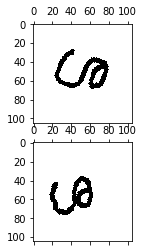

In [135]:
pair = 2103
fig,(ax1,ax2) = plt.subplots(2)
ax1.matshow(first[pair],cmap='gray')
ax2.matshow(second[pair],cmap='gray')

## Squash function

In [86]:
def squash(input_vector, axis):
    normalised_input = tf.reduce_sum(tf.square(input_vector), axis = axis, keepdims = True)
    scale = tf.divide(normalised_input, tf.add(normalised_input, 1.))
    vector = tf.divide(input_vector, tf.sqrt(tf.add(normalised_input, epsilon)))
    output = tf.multiply(scale, vector)
    
    return(output)

## Convolutional layer

In [87]:
def convolutional(input_data, conv_shape, stride_shape, name, relu=True):
    weights = tf.get_variable('W'+name, initializer=tf.truncated_normal(conv_shape, stddev=0.01))
    bias = tf.get_variable('B'+name, initializer=tf.truncated_normal([conv_shape[-1]], mean = 0.5, stddev=0.01))
    out_layer = tf.nn.conv2d(input_data, weights, stride_shape, padding = 'VALID')
    out_layer_bias = tf.add(out_layer, bias)
    
    if relu == True:
        out_layer_final = tf.nn.relu(out_layer_bias)
        return(out_layer_final, weights)

    return(out_layer_bias, weights)

## Primarycaps

In [88]:
def primarycaps(input_data, conv_shape, stride_shape, primaryCaps_channels, caps1_size, caps2_size, pose_size, batch):
    output, weights_primary = convolutional(input_data, conv_shape, stride_shape, relu=False, name='primaryCaps')
    filter_size = output.get_shape().as_list()[1]
    caps1_raw = tf.reshape(output, [-1,filter_size*filter_size*primaryCaps_channels,caps1_size], name='caps1_raw')
    caps1_output = squash(caps1_raw, axis=-1)
    caps1_output_expand = tf.expand_dims(caps1_output, axis=-1)
    caps1_output_expand2 = tf.expand_dims(caps1_output_expand, axis=2)
    caps1_output_expand2_tiled = tf.tile(caps1_output_expand2, [1,1,caps2_size,1,1], name = 'caps1_out_tiled')
    
    weight_matrix = tf.get_variable('Weight_matrix', initializer=tf.truncated_normal([filter_size*filter_size*primaryCaps_channels, caps2_size, pose_size, caps1_size], stddev=0.1))
    #weight_matrix_tiled = tf.tile(weight_matrix, [batch, 1, 1, 1, 1], name = 'W_matrix_tiled')
    #caps2_predicted = tf.matmul(weight_matrix_tiled, caps1_output_expand2_tiled, name='caps2_predicted')
    caps2_predicted = tf.einsum('abdc,iabcf->iabdf', weight_matrix, caps1_output_expand2_tiled)
    
    return(caps2_predicted, weights_primary, weight_matrix)

## Routing by agreement

In [89]:
def routing_by_agreement(input_data, caps2_size, rounds, batch):
    raw_weights = tf.zeros([batch, input_data.get_shape().as_list()[1], caps2_size, 1, 1], name = 'raw_weights')
    
    for i in range(rounds):
        routing_weights = tf.nn.softmax(raw_weights, axis=2, name = 'routing_weights' + str(i))
        weighted_predictions = tf.multiply(routing_weights, input_data, name = 'weighted_predictions' + str(i))
        weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, name = 'weighted_sum' + str(i), keepdims = True)
        caps2_output = squash(weighted_sum, axis=-2)
    
        #caps2_output_tiled = tf.tile(caps2_output, [1, input_data.get_shape().as_list()[1], 1, 1, 1], name = 'caps2_output_tiled'+ str(i))
        #agreement = tf.matmul(input_data, caps2_output_tiled, transpose_a = True, name = 'agreement'+ str(i))
        agreement = tf.einsum('iabcd,ifbcd->iabcd', input_data, caps2_output)
        raw_weights = tf.add(raw_weights, agreement, name = 'raw_weights' + str(i))
        
    return(caps2_output)

In [90]:
def create_dense_layer(input_data, input_shape, neurons, name):
    weights = tf.get_variable(name+'_W', initializer=tf.truncated_normal([input_shape, neurons], stddev=0.2))
    bias = tf.get_variable(name+'b', initializer=tf.truncated_normal([neurons], mean=0.5, stddev=0.01))
    fully_connected = tf.add(tf.matmul(input_data, weights), bias)
    out_dense_activation = tf.nn.sigmoid(fully_connected)
    
    return(out_dense_activation, weights)

## Graph

In [91]:
def create_network(caps1_size, caps2_size,pred_matrix_size,conv1_channels,conv1_filter,primaryCaps_channels,primaryCaps_filter,routing_rounds,X,fully_layer_size,stride_conv1,stride_conv2):
    conv1, weights_conv1 = convolutional(X, [conv1_filter,conv1_filter,X.get_shape().as_list()[-1],conv1_channels],[1,stride_conv1,stride_conv1,1], name='conv')
    primary, weights_primary, weight_matrix = primarycaps(conv1, [primaryCaps_filter,primaryCaps_filter,conv1.get_shape().as_list()[-1],
                              primaryCaps_channels*caps1_size], [1,stride_conv2,stride_conv2,1],primaryCaps_channels,
                      caps1_size,caps2_size, pred_matrix_size, batch=tf.shape(X)[0])
    output = routing_by_agreement(primary, caps2_size, routing_rounds, batch=tf.shape(X)[0])
    flat = tf.reshape(output, [-1, caps2_size*pred_matrix_size])
    fully_connected, weights_fc = create_dense_layer(flat, caps2_size*pred_matrix_size , fully_layer_size, 'fully')
    
    return(fully_connected, weights_conv1, weights_primary, weight_matrix, weights_fc)

In [92]:
def create_graph(learning_rate,beta1,beta2,caps1_size,caps2_size,pred_matrix_size,conv1_channels,conv1_filter,primaryCaps_channels,primaryCaps_filter,routing_rounds,fully_layer_size,stride_conv1,stride_conv2, lambda1, lambda2, lambda3, lambda4):
    X1 = tf.placeholder(tf.float32, [None, 105, 105, 1])
    X2 = tf.placeholder(tf.float32, [None, 105, 105, 1])
    y = tf.placeholder(tf.float32, [None, 1])

    with tf.variable_scope('siamese') as scope:
        output1, weights_conv1_1, weights_primary_1, weight_matrix_1, weights_fc_1 = create_network(caps1_size, caps2_size,pred_matrix_size,conv1_channels,conv1_filter,primaryCaps_channels,primaryCaps_filter,routing_rounds,X1,fully_layer_size,stride_conv1,stride_conv2)
        scope.reuse_variables()
        output2, _, _, _, _ = create_network(caps1_size, caps2_size,pred_matrix_size,conv1_channels,conv1_filter,primaryCaps_channels,primaryCaps_filter,routing_rounds,X2,fully_layer_size,stride_conv1,stride_conv2)

    l1_dis = tf.abs(tf.subtract(output1, output2))

    weights = tf.Variable(tf.truncated_normal([fully_layer_size, 1], stddev=0.03), name='w_final')
    bias = tf.Variable(tf.truncated_normal([1], stddev=0.01), name='b_final')
    fully_final = tf.add(tf.matmul(l1_dis, weights), bias)
    y_estimate = tf.nn.sigmoid(fully_final)

    cross_entropy = tf.add(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = fully_final)), lambda1 * tf.nn.l2_loss(weights_conv1_1) +
                           lambda2 * tf.nn.l2_loss(weights_primary_1) +
                           lambda3 * tf.nn.l2_loss(weight_matrix_1) +
                           lambda4 * tf.nn.l2_loss(weights_fc_1))
    
    optimiser = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=beta1, beta2=beta2).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.round(y_estimate), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype = tf.float32))
    
    return(optimiser, cross_entropy, accuracy, X1, X2, y)

## Setup training

In [93]:
learning_rate = 0.0161
beta1 = 0.9999
beta2 = 0.9647
caps1_size = 4
caps2_size = 32
pred_matrix_size = 8
conv1_channels = 160
conv1_filter = 10
primaryCaps_channels = 48
primaryCaps_filter = 14
routing_rounds = 2
fully_layer_size = 64
stride_conv1 = 3
stride_conv2 = 3
batch_size = 48
lambda1 = 8.097e-06
lambda2 = 1.412e-08
lambda3 = 4.705e-06
lambda4 = 0.0004176

In [136]:
epochs = 10
epsilon = 1e-7

#If run on AWS
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth=True


optimiser, cross_entropy, accuracy, X1, X2, y= create_graph(learning_rate,beta1,beta2,caps1_size,caps2_size,pred_matrix_size,conv1_channels,conv1_filter,primaryCaps_channels,primaryCaps_filter,routing_rounds,fully_layer_size,stride_conv1,stride_conv2, lambda1, lambda2, lambda3, lambda4)
accuracy_summary = tf.summary.scalar("Training_Accuracy_rotation5", accuracy)
summaries_dir = '../../logs-tensorboard'

init_op = tf.global_variables_initializer()
    
with tf.Session(config=config) as sess:
    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
    validation_writer = tf.summary.FileWriter(summaries_dir + '/val')
    summary_op = tf.summary.merge_all()
    init_op.run()
        
    total_batch = int(10000/batch_size)
    total_batch_val = int(3000/batch_size)

    for epoch in range(epochs):
        for i in range(1+(total_batch*epoch), total_batch+(total_batch*epoch)):
            batch_x1, batch_x2, batch_y = shuffle(train_set[0],train_set[1], train_labels, n_samples = batch_size)
            summary, a = sess.run([summary_op, optimiser], feed_dict={X1: batch_x1, X2: batch_x2, y: batch_y})
            train_writer.add_summary(summary, i)
            train_writer.flush()
            if i % 20 == 0:
                print('batch:', i)
            
            batch_x1, batch_x2, batch_y = shuffle(val_set[0],val_set[1], val_labels, n_samples = batch_size)
            summary = sess.run(summary_op, feed_dict={X1: batch_x1, X2: batch_x2, y: batch_y})
            validation_writer.add_summary(summary, i)
            validation_writer.flush()
            
        if epoch == epochs-1:
            test_val = 0
            for iterations in range(total_batch_val):
                batch_x1, batch_x2, batch_y = shuffle(test_set[0],test_set[1], test_labels, n_samples = batch_size)
                test_acc = sess.run(accuracy, feed_dict={X1: batch_x1, X2: batch_x2, y: batch_y})
                test_val += test_acc
            test_accuracy = test_val/total_batch_val
            print('test_acc:', test_accuracy)
        print('epoch:', epoch)

batch: 20
batch: 40
batch: 60
batch: 80
batch: 100
batch: 120
batch: 140
batch: 160
batch: 180
batch: 200
epoch: 0
batch: 220
batch: 240
batch: 260
batch: 280
batch: 300
batch: 320
batch: 340
batch: 360
batch: 380
batch: 400
epoch: 1
batch: 420
batch: 440
batch: 460
batch: 480
batch: 500
batch: 520
batch: 540
batch: 560
batch: 580
batch: 600
batch: 620
epoch: 2
batch: 640
batch: 660
batch: 680
batch: 700
batch: 720
batch: 740
batch: 760
batch: 780
batch: 800
batch: 820
epoch: 3
batch: 840
batch: 860
batch: 880
batch: 900
batch: 920
batch: 940
batch: 960
batch: 980
batch: 1000
batch: 1020
epoch: 4
batch: 1060
batch: 1080
batch: 1100
batch: 1120
batch: 1140
batch: 1160
batch: 1180
batch: 1200
batch: 1220
batch: 1240
epoch: 5
batch: 1260
batch: 1280
batch: 1300
batch: 1320
batch: 1340
batch: 1360
batch: 1380
batch: 1400
batch: 1420
batch: 1440
epoch: 6
batch: 1460
batch: 1480
batch: 1500
batch: 1520
batch: 1540
batch: 1560
batch: 1580
batch: 1600
batch: 1620
batch: 1640
batch: 1660
epoch:

In [132]:
tf.reset_default_graph()

Test accuracies of iterations:
1.  0.8649193567614402
2.	0.8615591420281318
3.	0.8736559123762192
4.  0.8481182811721679
5.  0.8571908627786944
6.  0.8595430139572390
7.  0.8555107539699923
8.  0.8484542985116282
9.  0.8450940847396851
10. 0.8242607520472619

In [38]:
test_scores = np.array([0.8649193567614402,
    0.8615591420281318,
    0.8736559123762192,
    0.8481182811721679,
    0.8571908627786944,
    0.8595430139572390,
    0.8555107539699923,
    0.8484542985116282,
    0.8450940847396851,
    0.8242607520472619])

In [46]:
meanscore = test_scores.mean()
print(test_scores.mean())
print(test_scores.std())

0.853830645834246
0.012785607794073396


test accuracies of rotated iterations:

1.  0.7745295714947485
2.  0.8121639788150787
3.  0.7678091401054014
4.  0.7217741906642914
5.  0.8007392498754686

In [137]:
rotation = np.array([0.7745295714947485,
0.8121639788150787,
0.7678091401054014,
0.7217741906642914,
0.8007392498754686])

In [138]:
rotation.mean()

0.7754032261909977

In [139]:
rotation.std()

0.031393546780054675